<a href="https://colab.research.google.com/github/Zen0007/classification_text_with_nlp/blob/main/rnn_for_tweet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 /root/.kaggle/kaggle.json
!kaggle competitions download -c nlp-getting-started

  0% 0.00/593k [00:00<?, ?B/s]
100% 593k/593k [00:00<00:00, 110MB/s]


In [ ]:
!unzip "/content/nlp-getting-started.zip" -d "/content/dataset/"

Archive:  /content/nlp-getting-started.zip
  inflating: /content/dataset/sample_submission.csv  
  inflating: /content/dataset/test.csv  
  inflating: /content/dataset/train.csv  


In [ ]:
!pip install transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 15.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.8/294.8 kB 20.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 52.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 57.1 MB/s eta 0:00:00


In [ ]:
!pip install wordcloud

In [ ]:
import numpy as np
import pandas as pd
import re
from PIL import Image
import nltk
import keras.backend as K
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from xgboost import XGBClassifier
from sklearn.metrics import  *
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from nltk.tokenize import word_tokenize
from nltk.stem import SnowballStemmer,WordNetLemmatizer
from nltk.corpus import stopwords
from tensorflow. keras.models import Sequential
from tensorflow. keras.layers import Dense, Embedding , LSTM, Dropout,GlobalAveragePooling1D,Flatten
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import one_hot
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.callbacks import *
from collections import Counter
from wordcloud import WordCloud,ImageColorGenerator,STOPWORDS
from transformers import AutoTokenizer,TFAutoModel
from sklearn.model_selection import train_test_split

nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [ ]:
test = pd.read_csv('/content/dataset/test.csv')
train = pd.read_csv('/content/dataset/train.csv')

In [ ]:
test.head()

,id,keyword,location,text,clean_text
0,0,NaN,NaN,just happened a terrible car crash,"[just, happened, a, terrible, car, crash]"
1,2,NaN,NaN,heard about earthquake is different cities s...,"[heard, about, , earthquake, is, different, ci..."
2,3,NaN,NaN,there is a forest fire at spot pond geese are...,"[there, is, a, forest, fire, at, spot, pond, ,..."
3,9,NaN,NaN,apocalypse lighting spokane wildfires,"[apocalypse, lighting, , , spokane, , wildfires]"
4,11,NaN,NaN,typhoon soudelor kills in china and taiwan,"[typhoon, soudelor, kills, , , in, china, and,..."


In [ ]:
twitter_png = np.array(Image.open('/content/twitter.jpg'))

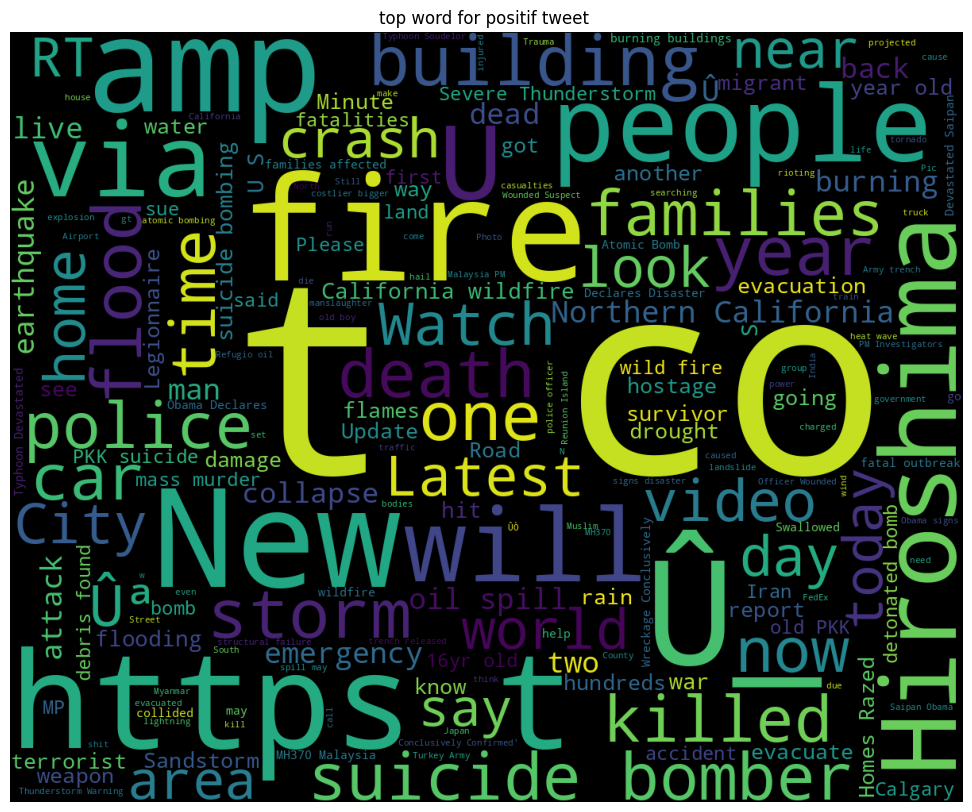

In [ ]:

wc = WordCloud(background_color='black',
               max_words=200,
               mask=twitter_png
               )
wc.generate(' '.join(text for text in train.loc[train['target']== 1 , 'text']))
plt.figure(figsize=(18,10))
plt.title('top word for positif tweet ')
plt.imshow(wc)
plt.axis('off')
plt.show()

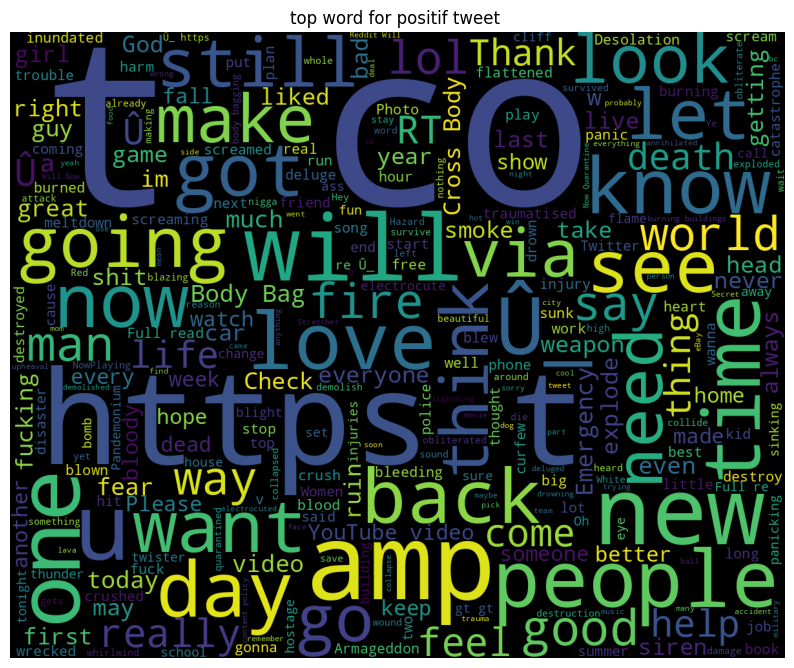

In [ ]:
wc = WordCloud(
               background_color='black',
               max_words=300,
               mask=twitter_png).generate(' '.join(text for text in train.loc[train['target']== 0 , 'text']))


plt.figure(figsize=(10,10))
plt.title('top word for positif tweet ')
plt.imshow(wc)
plt.axis('off')
plt.show()

In [ ]:
def clean_dateset (text):
  text = text.lower()
  text = re.sub(r'https?://\S+|www\.\S+|http?"//\S+',' ',text)
  text = re.sub(r'<.*?>',' ',text)
  text = re.sub(r'\x89\s+',' ',text)
  text = re.sub(r'\w*\d\w*',' ',text)
  text = re.sub(r'[^\w\s]',' ',text)
  texts = re.compile("["
                       u"\U0001F600-\U0001F64F"
                       u"\U0001F300-\U0001F5FF"
                       u"\U0001F680-\U0001F6FF"
                       u"\U0001F1E0-\U0001F1FF"
                       u"\U00002500-\U00002BEF"
                       u"\U00002702-\U000027B0"
                       u"\U00002702-\U000027B0"
                       u"\U000024C2-\U0001F251"
                       u"\U0001f926-\U0001f937"
                       u"\U00010000-\U0010ffff"
                       u"\u2640-\u2642"
                       u"\u2600-\u2B55"
                       u"\u200d"
                       u"\u23cf"
                       u"\u23e9"
                       u"\u231a"
                       u"\ufe0f"
                       u"\u3030"
                       "]+", flags=re.UNICODE)
  text = texts.sub(r' ', text)

  return text

def stiring(text):
  text = list(text.lower().split(" "))
  return text

train['text'] = train['text'].apply(clean_dateset)
train['clean_text'] = train['text'].apply(stiring)
test['text'] = test['text'].apply(clean_dateset)
test['clean_text'] = test['text'].apply(stiring)

In [ ]:
train.head()

,id,keyword,location,text,target,clean_text
0,1,NaN,NaN,our deeds are the reason of this earthquake m...,1,"[our, deeds, are, the, reason, of, this, , ear..."
1,4,NaN,NaN,forest fire near la ronge sask canada,1,"[forest, fire, near, la, ronge, sask, , canada]"
2,5,NaN,NaN,all residents asked to shelter in place are ...,1,"[all, residents, asked, to, , shelter, in, pla..."
3,6,NaN,NaN,people receive wildfires evacuation order...,1,"[, , , , people, receive, , wildfires, evacuat..."
4,7,NaN,NaN,just got sent this photo from ruby alaska as ...,1,"[just, got, sent, this, photo, from, ruby, , a..."


In [ ]:
test_data = test['id']
train_text = train.drop(['id','keyword','location','clean_text'],axis=1)
test_text = test.drop(['id','keyword','location','clean_text'],axis=1)

pre proccessing for model RNN

In [ ]:
x_data  = train.copy()
x_data.head()

,id,keyword,location,text,target,clean_text
0,1,NaN,NaN,our deeds are the reason of this earthquake m...,1,"[our, deeds, are, the, reason, of, this, , ear..."
1,4,NaN,NaN,forest fire near la ronge sask canada,1,"[forest, fire, near, la, ronge, sask, , canada]"
2,5,NaN,NaN,all residents asked to shelter in place are ...,1,"[all, residents, asked, to, , shelter, in, pla..."
3,6,NaN,NaN,people receive wildfires evacuation order...,1,"[, , , , people, receive, , wildfires, evacuat..."
4,7,NaN,NaN,just got sent this photo from ruby alaska as ...,1,"[just, got, sent, this, photo, from, ruby, , a..."


In [ ]:
stop_word = set(stopwords.words ('english'))
lem = WordNetLemmatizer()

In [ ]:
def preprocesing(text):
  text = re.sub(r'[^\w\s]',' ',text,re.UNICODE)
  text = text.lower()
  text = [lem.lemmatize(token) for token in text.split(" ")]
  text = [lem.lemmatize(token, "v") for token in text ]
  text = [word for word in text if not word in stop_word]
  text = " ".join(text)
  return text

x_data['clean_text'] = x_data.text.apply(lambda x : preprocesing(x))

x_data.head(10)

,id,keyword,location,text,target,clean_text
0,1,NaN,NaN,our deeds are the reason of this earthquake m...,1,deed reason earthquake may allah forgive u
1,4,NaN,NaN,forest fire near la ronge sask canada,1,forest fire near la ronge sask canada
2,5,NaN,NaN,all residents asked to shelter in place are ...,1,resident ask shelter place notify officer e...
3,6,NaN,NaN,people receive wildfires evacuation order...,1,people receive wildfire evacuation order ...
4,7,NaN,NaN,just got sent this photo from ruby alaska as ...,1,get send photo ruby alaska smoke wildfire po...
5,8,NaN,NaN,rockyfire update california hwy closed ...,1,rockyfire update california hwy close d...
6,10,NaN,NaN,flood disaster heavy rain causes flash flood...,1,flood disaster heavy rain cause flash flood ...
7,13,NaN,NaN,i m on top of the hill and i can see a fire in...,1,top hill see fire wood
8,14,NaN,NaN,there s an emergency evacuation happening now ...,1,emergency evacuation happen build across street
9,15,NaN,NaN,i m afraid that the tornado is coming to our a...,1,afraid tornado come area


In [ ]:
encoding = LabelEncoder()
encoding.fit(x_data.target.to_list())

y_train = encoding.transform(x_data.target.to_list())
y_test = encoding.transform(x_data.target.to_list())

Y_train = y_train.reshape(-1,1)
Y_test = y_test.reshape(-1,1)

print(y_train.shape)
print(y_test.shape)

(7613,)
(7613,)


In [ ]:
max_word = 6000
tokenizer = Tokenizer(num_words=max_word)
tokenizer.fit_on_texts(x_data.clean_text)

In [ ]:
max_len = 130
X_train = pad_sequences(tokenizer.texts_to_sequences(x_data.clean_text),maxlen=max_len)
X_test =  pad_sequences(tokenizer.texts_to_sequences(x_data.clean_text),maxlen=max_len)
X_train.shape,X_test.shape

((7613, 130), (7613, 130))

pre proccessing for model trasformers


In [ ]:
K.clear_session()
model_1 = "bert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_1,do_lower_case=True,max_length = 36)

x_train = tokenizer(
    text = train_text['text'].tolist(),
    add_special_tokens = True,
    max_length = 36,
    truncation = True,
    padding = True,
    return_tensors = "tf",
    return_token_type_ids = False,
    return_attention_mask = True,
    verbose = True
)

x_test = tokenizer(
    text = test_text['text'].tolist(),
    add_special_tokens = True,
    max_length = 36,
    truncation = True,
    padding = True,
    return_tensors = "tf",
    return_token_type_ids = False,
    return_attention_mask = True,
    verbose = True
)



In [ ]:
bert = TFAutoModel.from_pretrained(model_1)

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

In [ ]:
input_ids = tf.keras.layers.Input(shape = 36,dtype= tf.int32,name = "input_ids")
input_max = tf.keras.layers.Input(shape = 36,dtype= tf.int32,name = "attention_mask")
embedding = bert(input_ids, attention_mask=input_max)[1]
x = tf.keras.layers.Dropout(0.3)(embedding)
x = tf.keras.layers.Dense(128,activation = 'relu')(x)
x = tf.keras.layers.Dropout(0.2)(x)
x  = tf.keras.layers.Dense(32,activation = 'relu')(x)
output = tf.keras.layers.Dense(1,activation = 'sigmoid')(x)
model = tf.keras.Model(inputs = [input_ids,input_max], outputs = output)

In [ ]:
model.layers[2].trainabel = True
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_ids (InputLayer)      [(None, 36)]                 0         []                            
                                                                                                  
 attention_mask (InputLayer  [(None, 36)]                 0         []                            
 )                                                                                                
                                                                                                  
 tf_bert_model (TFBertModel  TFBaseModelOutputWithPooli   1094822   ['input_ids[0][0]',           
 )                           ngAndCrossAttentions(last_   40         'attention_mask[0][0]']      
                             hidden_state=(None, 36, 76                                       

In [ ]:
model.compile(loss = tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer = tf.keras.optimizers.legacy.Adam(lr = 5e-5,epsilon = 1e-8,decay = 0.01,clipnorm=1.0),
              metrics = ["accuracy"]
              )

/usr/local/lib/python3.10/dist-packages/keras/src/optimizers/legacy/adam.py:118: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [ ]:
his = model.fit(x = {"input_ids": x_train["input_ids"],
                     "attention_mask": x_train["attention_mask"]},
                y = train['target'],
                epochs=10,
                validation_split=0.2,
                batch_size = 128,
                )

Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/backend.py:5805: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Sigmoid activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


48/48 [==============================] - 73s 913ms/step - loss: 0.5529 - accuracy: 0.7319 - val_loss: 0.4261 - val_accuracy: 0.8089
Epoch 2/10
48/48 [==============================] - 42s 868ms/step - loss: 0.3866 - accuracy: 0.8481 - val_loss: 0.3896 - val_accuracy: 0.8260
Epoch 3/10
48/48 [==============================] - 44s 921ms/step - loss: 0.3245 - accuracy: 0.8821 - val_loss: 0.4236 - val_accuracy: 0.8148
Epoch 4/10
48/48 [==============================] - 44s 914ms/step - loss: 0.2679 - accuracy: 0.9048 - val_loss: 0.4443 - val_accuracy: 0.8135
Epoch 5/10
48/48 [==============================] - 44s 916ms/step - loss: 0.2349 - accuracy: 0.9177 - val_loss: 0.4752 - val_accuracy: 0.8096
Epoch 6/10
48/48 [==============================] - 44s 916ms/step - loss: 0.2001 - accuracy: 0.9342 - val_loss: 0.5094 - val_accuracy: 0.8227
Epoch 7/10
48/48 [==============================] - 42s 876ms/step - loss: 0.1604 - accuracy: 0.9484 - val_loss: 0.5609 - val_accuracy: 0.8017
Epoch 8/10

In [ ]:
Models_trasformers = model.predict({"input_ids" : x_test["input_ids"],"attention_mask": x_test["attention_mask"]})
pred = np.where(Models_trasformers > 0.5 , 1,0)

102/102 [==============================] - 12s 83ms/step


In [ ]:
result = pd.DataFrame()
result['id'] = test['id']
result['target'] = pred
result.head()

,id,target
0,0,1
1,2,1
2,3,1
3,9,1
4,11,1


model rnn with embedding

In [ ]:
embedding_dim = 130
model_rnn = Sequential()
model_rnn.add(Embedding(max_word,embedding_dim))
model_rnn.add(Dropout(0.2))
model_rnn.add(LSTM(64,dropout=0.2,recurrent_dropout=0.2))
model_rnn.add(Dense(1,activation='sigmoid'))
model_rnn.compile(loss='binary_crossentropy',optimizer=tf.keras.optimizers.Adam(),metrics=['accuracy'])
model_rnn.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 130)         780000    
                                                                 
 dropout (Dropout)           (None, None, 130)         0         
                                                                 
 lstm (LSTM)                 (None, 64)                49920     
                                                                 
 dense (Dense)               (None, 1)                 65        
                                                                 
Total params: 829985 (3.17 MB)
Trainable params: 829985 (3.17 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
hist=model_rnn.fit(X_train,Y_train,
               epochs=15,
               verbose=1,
               batch_size=256,
               validation_split=0.1
               )

Epoch 1/15
27/27 [==============================] - 29s 783ms/step - loss: 0.6568 - accuracy: 0.6028 - val_loss: 0.6482 - val_accuracy: 0.6470
Epoch 2/15
27/27 [==============================] - 21s 795ms/step - loss: 0.4875 - accuracy: 0.7959 - val_loss: 0.4471 - val_accuracy: 0.7953
Epoch 3/15
27/27 [==============================] - 18s 678ms/step - loss: 0.3411 - accuracy: 0.8613 - val_loss: 0.4553 - val_accuracy: 0.7913
Epoch 4/15
27/27 [==============================] - 19s 693ms/step - loss: 0.2750 - accuracy: 0.8923 - val_loss: 0.4937 - val_accuracy: 0.7743
Epoch 5/15
27/27 [==============================] - 20s 753ms/step - loss: 0.2357 - accuracy: 0.9079 - val_loss: 0.5312 - val_accuracy: 0.7677
Epoch 6/15
27/27 [==============================] - 18s 660ms/step - loss: 0.2015 - accuracy: 0.9235 - val_loss: 0.5799 - val_accuracy: 0.7703
Epoch 7/15
27/27 [==============================] - 18s 661ms/step - loss: 0.1810 - accuracy: 0.9314 - val_loss: 0.6464 - val_accuracy: 0.7598

In [ ]:
y_pred = model_rnn.predict(X_test)
y_pred = y_pred.astype('float64')
y_pred

238/238 [==============================] - 9s 38ms/step


array([[0.99903059],
       [0.99998748],
       [0.9996922 ],
       ...,
       [0.99940038],
       [0.99996173],
       [0.99999487]])

In [ ]:
binary_pred = (y_pred >= 0.5).astype(int)
binary_pred.shape,y_train.shape

((7613, 1), (7613,))

In [ ]:
result = pd.DataFrame()
result['id'] = x_data['id']
result['target'] = binary_pred
result.head()

,id,target
0,1,1
1,4,1
2,5,1
3,6,1
4,7,1


In [ ]:
finis = result.iloc[:3263,:]
finis['id'] = test['id']
finis.head()

<ipython-input-41-09bc96fce445>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  finis['id'] = test['id']


,id,target
0,0,1
1,2,1
2,3,1
3,9,1
4,11,1


In [ ]:
finis.to_csv('submission.csv',index=False)

In [ ]:
accuracy = accuracy_score(Y_test,binary_pred)
precision = precision_score(Y_test,binary_pred)
recal = recall_score(Y_test,binary_pred)
f1 = f1_score(Y_test,binary_pred)
print('accuracy ',accuracy)
print('precision',precision)
print('recal    ',recal)
print('F1 score ',f1)

accuracy  0.9503480887954814
precision 0.949363156259708
recal     0.9342708651788444
F1 score  0.9417565485362095


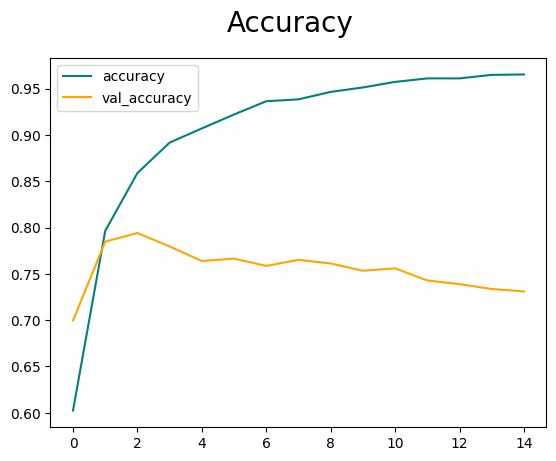

In [ ]:
fig = plt.figure()
plt.plot(hist.history['accuracy'],color='teal',label='accuracy')
plt.plot(hist.history['val_accuracy'],color='orange',label='val_accuracy')
fig.suptitle('Accuracy',fontsize=20)
plt.legend(loc="upper left")
plt.show()

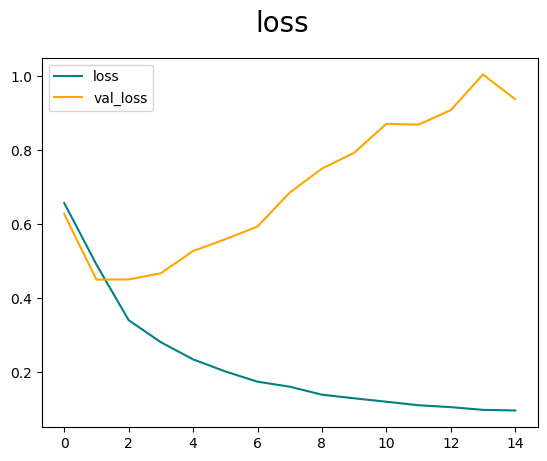

In [ ]:
fig = plt.figure()
plt.plot(hist.history['loss'],color='teal',label='loss')
plt.plot(hist.history['val_loss'],color='orange',label='val_loss')
fig.suptitle('loss',fontsize=20)
plt.legend(loc="upper left")
plt.show()

Linear Regresion


In [ ]:
model_linear = LogisticRegression()
model_linear.fit(X_train,Y_train)
pred = model_linear.predict(X_test)

/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [ ]:
cr = classification_report(Y_test,pred)
print(cr)

              precision    recall  f1-score   support

           0       0.57      0.94      0.71      4342
           1       0.48      0.08      0.13      3271

    accuracy                           0.57      7613
   macro avg       0.53      0.51      0.42      7613
weighted avg       0.54      0.57      0.46      7613



In [ ]:
result = pd.DataFrame()
result['id'] = x_data['id']
result['target'] = pred
result.head()

,id,target
0,1,0
1,4,0
2,5,0
3,6,0
4,7,0


In [ ]:
model_linear = XGBClassifier()
model_linear.fit(X_train,y_train)
pred2 = model_linear.predict(X_test)
cr = classification_report(Y_test,pred2)
print(cr)

              precision    recall  f1-score   support

           0       0.91      0.98      0.94      4342
           1       0.97      0.87      0.92      3271

    accuracy                           0.93      7613
   macro avg       0.94      0.92      0.93      7613
weighted avg       0.93      0.93      0.93      7613



In [ ]:
result = pd.DataFrame()
result['id'] = x_data['id']
result['target'] = pred2
result.head()

,id,target
0,1,1
1,4,1
2,5,1
3,6,1
4,7,0


In [ ]:
!kaggle competitions submit -c nlp-getting-started -f submission.csv -m "finish"

100% 22.2k/22.2k [00:02<00:00, 7.62kB/s]
Successfully submitted to Natural Language Processing with Disaster Tweets